## Large Language Model Experiment: Using Mistral

This experiment evaluates the performance of Mistral-7B model on the multiclass aphasia classification task.

Unlike traditional machine learning models that rely on explicit feature engineering or transformer-based classifiers trained end-to-end, Mistral is used here in a zero-shot or few-shot setting to directly predict aphasia subtypes based on full patient utterances.

 The prompt design was carefully structured to include task-specific instructions and representative examples when applicable. This LLM-based evaluation complements the benchmarking study by offering insight into the capabilities of foundation models on clinical text with limited labeled data and subtle syntactic distinctions.

In [1]:
import pandas as pd
import io
import os
from transformers import pipeline
import torch

In [1]:
# import data here

In [3]:
df['Subtype'].value_counts()

Subtype
control    53
nfvPPA     29
lvPPA      26
svPPA      24
Name: count, dtype: int64

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:

model_id = "mistralai/Mistral-7B-Instruct-v0.2"
pipeline = pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
# Define the system message for a classifier role
system_message = {
    "role": "system",
    "content": """You are a clinical text classifier specializing in language and speech characteristics related to Primary Progressive Aphasia (PPA). Based on the provided interview transcript of a patient, classify the text into one of the following categories:

- **lvPPA**: Logopenic Variant, Characterized by word-finding difficulties and impaired repetition abilities. Patients may frequently pause or hesitate as they search for words, and they may struggle to repeat phrases accurately.
  - **Example**: Patient might say, “I went to the… um… place where… you know, people get… books,” when trying to say "library." They may also struggle to repeat phrases accurately, often omitting words or stumbling.
- **svPPA**: Semantic Variant, Primarily affects the understanding of word meanings (semantic knowledge). Patients may struggle with naming and comprehension, even for common objects. They often resort to broad categories instead of precise words (e.g., thing instead of fork)
  - **Example**: When shown a picture of a dog, the patient might say, “It’s an animal… I think it’s a pet,” without being able to retrieve the word "dog." They may also have difficulty understanding specific terms, relying on broader descriptions.
- **nfvPPA**: Impacts grammar and speech production, leading to slow, effortful, and agrammatic speech. Patients may omit small grammatical words (e.g., “is,” “the”) and speak in a telegraphic manner. Patients tend to use very short sentences, a rich vocabulary with low-frequency words, and more nouns compared to verbs.
  - **Example**: The patient might say, “Walk… store… buy milk,” instead of “I’m going to walk to the store to buy milk.” Speech is often halting and labor-intensive, with noticeable pauses.
- **control**: The individual demonstrates fluent, grammatically correct speech, free from any markers of hesitation, effortful speech, or semantic impairment. There are no indications of word-finding difficulties or grammatical errors. The individual uses both simple and complex sentences naturally and appropriately. They can express themselves clearly without notable pauses, hesitations, or substitutions. The vocabulary used is appropriate for the context, and their language comprehension and responses are cohesive.
  - **Example**: “I’m going to walk to the store to buy some milk” or “After I finish work, I plan to go for a walk and then cook dinner.” The language is fluent, natural, and demonstrates coherent sentence-building abilities.
Analyze the language, sentence structure, vocabulary, and speech flow within the conversational context of the interview to determine the most fitting category. Your response should include only one of the following labels: **lvPPA**, **svPPA**, **nfvPPA**, or **control**, if the text does not clearly fit into one category, analyze it carefully and suggest the most likely category based on available evidence."""
}

In [7]:
def classify_text(text):
    messages = [
        system_message,
        {"role": "user", "content": f"Classify this text: {text}"}
    ]
    
    # use a single EOS token ID
    eos_token_id = pipeline.tokenizer.eos_token_id
    
    # run the classification
    output = pipeline(
        messages,
        max_new_tokens=150,
        eos_token_id=eos_token_id,
        do_sample=True,
        temperature=0.2,
        top_p=0.9,
    )
    
    # print raw output for debugging
    print("Raw Output:", output)
    
    # extract the generated label
    try:
        # extract assistant content
        assistant_content = output[0]["generated_text"][-1]["content"]
        
        print("Assistant Content:", assistant_content)
        
        # parse the label
        label = "Unknown"
        if "**" in assistant_content:
            parts = assistant_content.split("**")
            if len(parts) > 1:
                label = parts[1].strip().split()[0]
    except (IndexError, KeyError, TypeError) as e:
        print(f"Error extracting label: {e}")
    
    return label

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Raw Output: [{'generated_text': [{'role': 'system', 'content': 'You are a clinical text classifier specializing in language and speech characteristics related to Primary Progressive Aphasia (PPA). Based on the provided interview transcript of a patient, classify the text into one of the following categories:\n\n- **lvPPA**: Logopenic Variant, Characterized by word-finding difficulties and impaired repetition abilities. Patients may frequently pause or hesitate as they search for words, and they may struggle to repeat phrases accurately.\n  - **Example**: Patient might say, “I went to the… um… place where… you know, people get… books,” when trying to say "library." They may also struggle to repeat phrases accurately, often omitting words or stumbling.\n- **svPPA**: Semantic Variant, Primarily affects the understanding of word meanings (semantic knowledge). Patients may struggle with naming and comprehension, even for common objects. They often resort to broad categories instead of preci

In [ ]:
df['PredictedLabel'] = df['Text'].apply(lambda text: classify_text(text))

In [13]:
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, classification_report
import pandas as pd

true_labels = df['Subtype'] 
predicted_labels = df['PredictedLabel']  

true_labels = true_labels.astype(str)
predicted_labels = predicted_labels.astype(str)


# Compute F1-score (macro-averaged)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

# Compute balanced accuracy
balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)

# Compute precision (macro-averaged)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)

# Compute recall (macro-averaged)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)

# Print results
print("F1 Score (weighted):", f1)
print("Balanced Accuracy:", balanced_acc)
print("Precision (weighted):", precision)
print("Recall (weighted):", recall)


F1 Score (weighted): 0.1418753068237604
Balanced Accuracy: 0.08687106918238993
Precision (weighted): 0.21866391184573003
Recall (weighted): 0.12121212121212122


/home/ghofrane/anaconda3/envs/ppa/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [12]:
# with the help of chatGPT
from sklearn.metrics import confusion_matrix

# get unique classes
classes = df['Subtype'].unique()

# initialize a dictionary to store results
balanced_accuracy_per_class = {}

# compute confusion matrix
cm = confusion_matrix(df['Subtype'], df['PredictedLabel'], labels=classes)

# calculate balanced accuracy for each class
for idx, cls in enumerate(classes):
    tp = cm[idx, idx]  # true positives for the class
    fn = cm[idx, :].sum() - tp  # false negatives
    fp = cm[:, idx].sum() - tp  # false positives
    tn = cm.sum() - (tp + fn + fp)  # true negatives

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # true positive rate
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # true negative rate
    balanced_accuracy = (sensitivity + specificity) / 2

    balanced_accuracy_per_class[cls] = balanced_accuracy

# Print balanced accuracy per class
for cls, acc in balanced_accuracy_per_class.items():
    print(f"Balanced Accuracy ({cls}): {acc:.2f}")

Balanced Accuracy (nfvPPA): 0.42
Balanced Accuracy (lvPPA): 0.47
Balanced Accuracy (control): 0.72
Balanced Accuracy (svPPA): 0.58


F1 Score (macro): 0.11342409603279169
Balanced Accuracy: 0.1080161570158317
Precision (macro): 0.24
Recall (macro): 0.08641292561266536

Confusion Matrix:
[[ 0 10 10  1  5]
 [ 0  0  0  0  0]
 [ 0  9  3  0 17]
 [ 3 13  2  2  4]
 [ 0 40  0  0 13]]


/home/ghofrane/anaconda3/envs/ppa/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


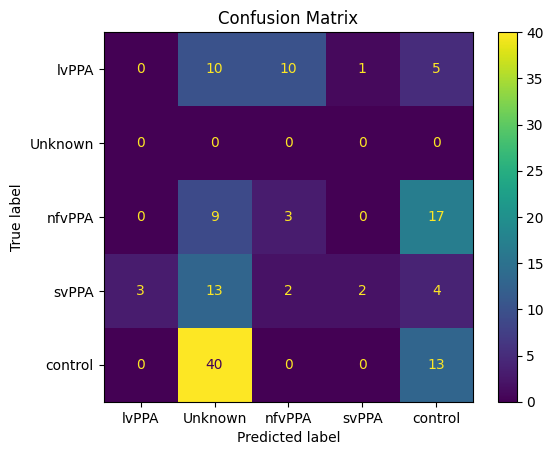

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels = df['Subtype'] 
predicted_labels = df['PredictedLabel'] 

# Convert to string type
true_labels = true_labels.astype(str)
predicted_labels = predicted_labels.astype(str)

# Compute classification metrics
f1 = f1_score(true_labels, predicted_labels, average='macro', zero_division=0)
balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='macro', zero_division=0)

# Print metrics
print("F1 Score (macro):", f1)
print("Balanced Accuracy:", balanced_acc)
print("Precision (macro):", precision)
print("Recall (macro):", recall)

# Compute confusion matrix
labels = list(set(true_labels).union(set(predicted_labels)))  # Include all labels, even "Unknown"
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=labels)

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
custom_cmap = plt.cm.viridis
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap=custom_cmap, values_format='d')
plt.title("Confusion Matrix")
plt.show()
